In [ ]:
pip install alpha_vantage

In [ ]:
from alpha_vantage.timeseries import TimeSeries

In [ ]:
apikey="YOUR API KEY" 

In [ ]:
ts = TimeSeries(key=apikey, output_format='pandas')

In [ ]:
msft, meta_data = ts.get_daily(symbol='msft', outputsize='full')

In [ ]:
print(msft.head())

            1. open  2. high  3. low  4. close   5. volume
date                                                      
2024-03-08   407.96   410.42  404.33    406.22  18002186.0
2024-03-07   406.12   409.78  402.24    409.14  18718479.0
2024-03-06   402.97   405.16  398.39    402.09  22344149.0
2024-03-05   413.96   414.25  400.64    402.65  26919177.0
2024-03-04   413.44   417.35  412.32    414.92  17595956.0


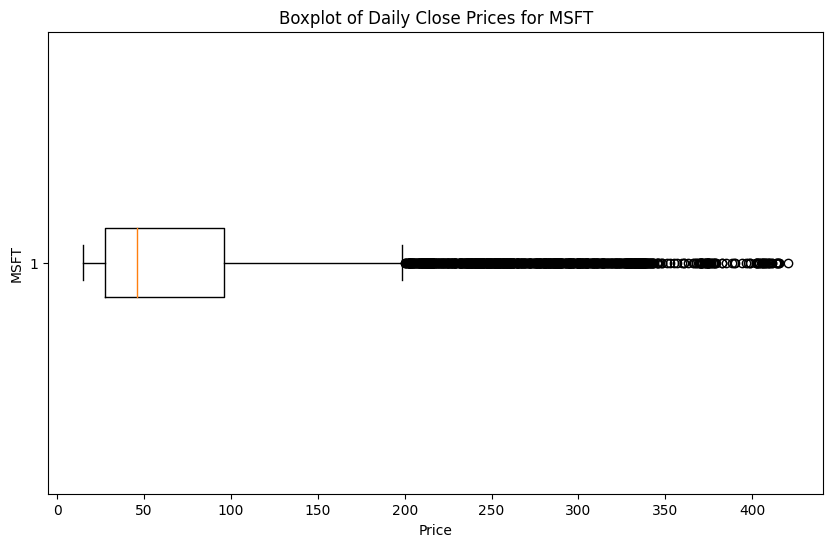

In [ ]:
import matplotlib.pyplot as plt

# Plotting the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(msft['4. close'], vert=False)
plt.title('Boxplot of Daily Close Prices for MSFT')
plt.xlabel('Price')
plt.ylabel('MSFT')
plt.show()


In [ ]:
msft.to_csv('msft_daily_prices.csv')

In [ ]:
import pandas as pd

df=pd.read_csv('msft_daily_prices.csv')

In [ ]:
df.head()

,date,1. open,2. high,3. low,4. close,5. volume
0,2024-03-08,407.96,410.42,404.33,406.22,18002186.0
1,2024-03-07,406.12,409.78,402.24,409.14,18718479.0
2,2024-03-06,402.97,405.16,398.39,402.09,22344149.0
3,2024-03-05,413.96,414.25,400.64,402.65,26919177.0
4,2024-03-04,413.44,417.35,412.32,414.92,17595956.0


In [ ]:
features = ['1. open', '4. close', '2. high', '3. low']

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [ ]:
from sklearn.svm import OneClassSVM
model = OneClassSVM(nu=0.05)
model.fit(df[features])

OneClassSVM(nu=0.05)

In [ ]:
anomaly_scores_svm = model.decision_function(df[features])
anomaly_scores_svm.size

6127

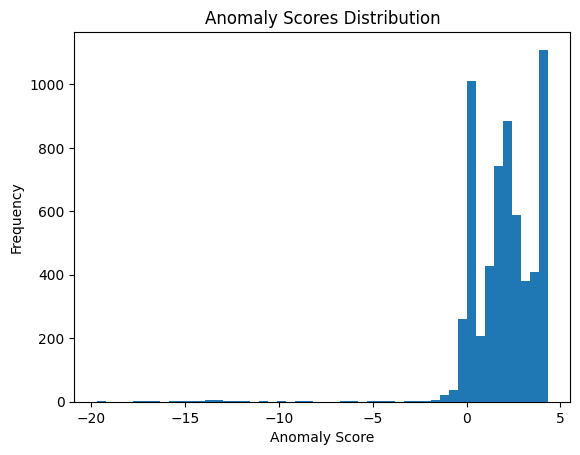

In [ ]:
plt.hist(anomaly_scores_svm, bins=50)
plt.title('Anomaly Scores Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import numpy as np

threshold = np.percentile(anomaly_scores_svm, 5)  # Example: consider 5th percentile as threshold

# Flag anomalies based on the threshold
df['is_anomaly'] = anomaly_scores_svm < threshold

# Print detected anomalies
anomalies = df[df['is_anomaly']]
print("Detected anomalies:")
num_rows, num_cols = anomalies.shape
print(num_rows)

Detected anomalies:
307


In [ ]:
from sklearn.ensemble import IsolationForest
import numpy as np

# Fit the model
clf = IsolationForest(contamination=0.1, random_state=42)
clf.fit(df[features])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.1, random_state=42)

In [ ]:
anomaly_scores_if = clf.decision_function(df[features])
anomaly_scores_if.size

6127

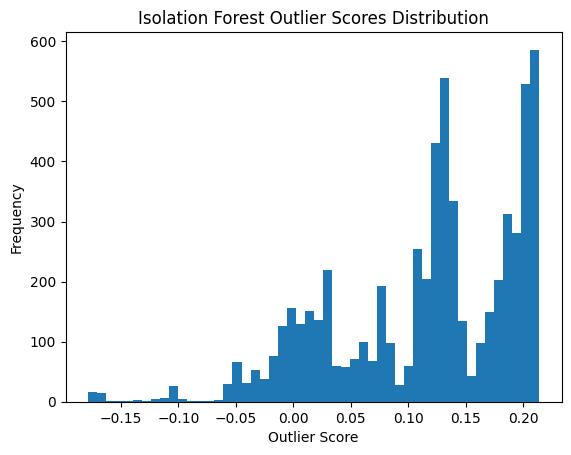

In [ ]:
plt.hist(anomaly_scores_if, bins=50)
plt.xlabel('Outlier Score')
plt.ylabel('Frequency')
plt.title('Isolation Forest Outlier Scores Distribution')
plt.show()

In [ ]:
# Predict outliers
y_pred = clf.predict(df[features])

# Flag anomalies based on the Isolation Forest predictions
df['is_anomaly'] = y_pred == -1

# Print detected anomalies
anomalies = df[df['is_anomaly']]
print("Detected anomalies:")
num_rows, num_cols = anomalies.shape
print(num_rows)

Detected anomalies:
613


In [ ]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=5, contamination=0.1)
y_pred = lof.fit_predict(df[features])

In [ ]:
df['is_anomaly'] = y_pred == -1

# Print detected anomalies
anomalies = df[df['is_anomaly']]
print("Detected anomalies:")
num_rows, num_cols = anomalies.shape
print(num_rows)

Detected anomalies:
613


In [ ]:
from sklearn.model_selection import train_test_split
X_scaled = df[features]
X_train, X_test = train_test_split(X_scaled, test_size=0.3, random_state=42)

In [ ]:
# Define the architecture of the autoencoder

input_dim = len(features)  # Number of features
encoding_dim = 32

In [ ]:
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Input, Dense

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=64, shuffle=True, validation_data=(X_test, X_test))

# Use the trained autoencoder to reconstruct the input data
reconstructed_data = autoencoder.predict(df[features])

# Calculate reconstruction error for each data point
mse = np.mean(np.power(X_scaled - reconstructed_data, 2), axis=1)

# Identify anomalies
threshold = np.percentile(mse, 5)

# Flag anomalies based on the threshold
df['is_anomaly'] = mse < threshold

# Print detected anomalies
anomalies = df[df['is_anomaly']]
print("Detected anomalies:")
num_rows, num_cols = anomalies.shape
print(num_rows)

Epoch 1/50
67/67 [==============================] - 1s 6ms/step - loss: 0.6643 - val_loss: 0.6277
Epoch 2/50
67/67 [==============================] - 0s 3ms/step - loss: 0.6008 - val_loss: 0.6274
Epoch 3/50
67/67 [==============================] - 0s 3ms/step - loss: 0.6006 - val_loss: 0.6272
Epoch 4/50
67/67 [==============================] - 0s 3ms/step - loss: 0.6004 - val_loss: 0.6271
Epoch 5/50
67/67 [==============================] - 0s 3ms/step - loss: 0.6003 - val_loss: 0.6270
Epoch 6/50
67/67 [==============================] - 0s 3ms/step - loss: 0.6003 - val_loss: 0.6269
Epoch 7/50
67/67 [==============================] - 0s 3ms/step - loss: 0.6002 - val_loss: 0.6269
Epoch 8/50
67/67 [==============================] - 0s 3ms/step - loss: 0.6002 - val_loss: 0.6269
Epoch 9/50
67/67 [==============================] - 0s 3ms/step - loss: 0.6002 - val_loss: 0.6269
Epoch 10/50
67/67 [==============================] - 0s 3ms/step - loss: 0.6002 - val_loss: 0.6269
Epoch 11/50
67/67 [

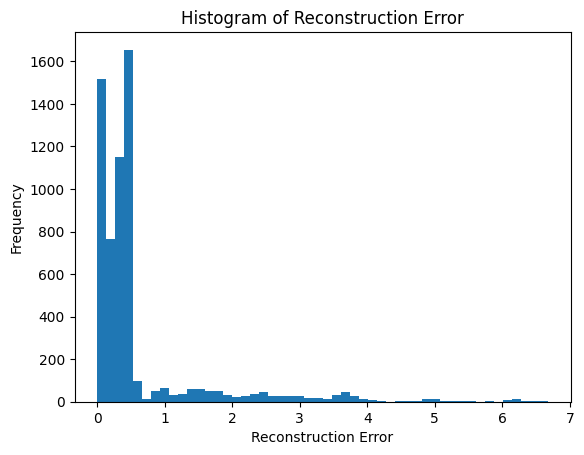

In [ ]:
# Visualize reconstruction error
plt.hist(mse, bins=50)
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Histogram of Reconstruction Error")
plt.show()

LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
sequence_length = 10  # Adjust as needed
# Create sequences for training
sequences = []
for i in range(len(X_scaled) - sequence_length):
    sequences.append(X_scaled[i:i+sequence_length])

# Convert list of sequences to array
sequences = np.array(sequences)

# Split data into input and target
X_train = sequences[:, :-1]  # All but the last time step as input
y_train = sequences[:, -1]   # Last time step as target

# Define LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(X_train.shape[2]))  # Output layer with same number of features as input
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, shuffle=True)

# Make predictions on the training data
y_pred = model.predict(X_train)

# Calculate reconstruction error for each data point
mse = np.mean(np.power(y_train - y_pred, 2), axis=1)

# Calculate the threshold
threshold = np.percentile(mse, 95)  # Example: consider 95th percentile as threshold

# Flag anomalies based on the threshold
num_additional_zeros = len(df) - len(mse) + sequence_length - 1
anomaly_flags = np.concatenate((np.zeros(num_additional_zeros, dtype=bool), mse > threshold))

# Ensure lengths match without padding or trimming
anomaly_flags = anomaly_flags[:len(df)]

# Assign the anomaly flags to the DataFrame
df['is_anomaly'] = anomaly_flags

# Print detected anomalies
anomalies = df[df['is_anomaly']]
print("Detected anomalies:")
num_rows, num_cols = anomalies.shape
print(num_rows)


Epoch 1/50
96/96 [==============================] - 3s 8ms/step - loss: 0.0771
Epoch 2/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0026
Epoch 3/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0014
Epoch 4/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0013
Epoch 5/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0013
Epoch 6/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0011
Epoch 7/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0011
Epoch 8/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0011
Epoch 9/50
96/96 [==============================] - 1s 10ms/step - loss: 0.0010
Epoch 10/50
96/96 [==============================] - 1s 12ms/step - loss: 0.0010
Epoch 11/50
96/96 [==============================] - 1s 11ms/step - loss: 9.4579e-04
Epoch 12/50
96/96 [==============================] - 1s 8ms/step - loss: 9.6180e-04
Epoch 13/50
96/96 [===================

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create a new DataFrame without the date column
data = df.drop(columns=['date'])


# Assuming df contains both features and target variable
# Separate features and target variable
X = data.drop(columns=['is_anomaly'])
y = data['is_anomaly']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a KNN classifier object
k = 3  # Define the value of k
knn = KNeighborsClassifier(n_neighbors=k)

# Train the KNN classifier
knn.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = knn.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9412724306688418
